# Heat-wave: Change under climate scenarios workflow [Hazard assessment]

# Step 1: Description

**Content:**
- Sources of the Heat-related products provided by **CDS** and **Climate adapt**
- Heat-wave hazard estimation based on the **Peseta IV** methodology

### Sources of the Heat wave related products.

**Copernicus Climate Data store:**

1. **Heat wave days and heat related mortality for nine European cities** (Valencia, Barcelona, Roma, Milan, Munich, Paris, Athens, London Budapest) derived from climate projections [[source](https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-urban-heat-related-mortality-projections?tab=app)]

2. **Heat wave days for Europe derived from ERA5 reanalysis** - NUTS 3 level [[source](https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heat-waves-current-climate?tab=app)]
    - This application allows users to explore the number of heat waves in European countries based on the ERA5 hourly data on single levels dataset.
A heat wave is a prolonged period of high temperature, relative to the region. A number of qualifying definitions of heat waves are used in the climate and health communities. This application presents two European-wide definitions: the Climatological EURO-CORDEX and Euroheat project , and one set of National definitions which are available for a limited number of European countries.

3. **Heat wave days for European countries derived from climate projections** [[source](ds.climate.copernicus.eu/cdsapp#!/software/app-health-heat-waves-projections?tab=app)]
    - This application is an exploratory tool for the Heat waves and cold spells in Europe derived from climate projections dataset. This dataset provides 30 year rolling means of the number of heat wave days based on bias adjusted output from the EURO-CORDEX ensemble of climate models.
A heat wave is a prolonged period of high temperature, relative to the region. A number of qualifying definitions of heat waves are used in the climate and health communities. This application presents two European-wide definitions: the Climatological EURO-CORDEX and Euroheat project , and one set of National definitions which are available for a limited number of European countries.
        

**Climate adapt:**

1. **Heat days occurrence in the past** [[Climate adapt heat days](https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days)]
2. **Heat days occurrence in the future** [[Climate adapt heat wave](https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days)]
3. **Tropical nights** [[Climate adapt Tropical nights](https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/)]

### Heat-Wave Hazard methodology description

**Heat-wave based on the PESETA IV methodology** [[PESETA IV project](https://joint-research-centre.ec.europa.eu/peseta-projects/jrc-peseta-iv_en)]
Specifically, a heat-wave is defined as a period ≥ 3 consecutive days with a maximum temperature above a daily threshold calculated for a 30-year-long reference period (for testing we choose a shorter period). At least a 30-year time series of daily values is needed to obtain a robust estimation of the indicator. The threshold is defined as the 90th percentile of daily maxima temperature, centered on a 31-day window (we used a month).

**Pros [+]**
- estimation of the yearly and monthly(seasonal) values
- 12x12km grid for years 1971-2000, 2011-2100
- the possibility of changing the temperature and day threshold (eg. 90 percentile and 3 days for the heatwave identification)
- the treshold is estimated for each pixel 
- This methodology is better for estimating the heat not only for the summer months but also the heat occurrence for the winter and autumn months because the treshold is counted for each month from the 30 years 1971-2000, so we can detect the seasonal changes.

**Cons [-]**
- Long time for computation - for years and months (all RCPs and years for Catalunya = 50 min)  
- Do not count with minimum air temperature - especially in the mountainous regions the heat can cool down at night
- 20 GB of input data 

# Step 2: Prepare a workspace and load a libraries

### Import packages

In [ ]:
import zipfile        # working with the zip folders #
import os             # handling the current working directory
import rasterio       # netcdf and raster processing  #
from pathlib import Path # file system paths
import rioxarray as rxr # netcdf and raster processing
import rioxarray
import cdsapi         # API downloading
import numpy as np    # 2-3D array data handling
import pandas as pd   # data handling #
import xarray as xr   # 2-3D array data handling 
import cartopy.crs as ccrs # netcdf data projection 
import cartopy.feature as cf # netcdf data projection 
import cartopy.crs as ccrs # netcdf data projection 
import matplotlib as mpl  #  data plot #
import matplotlib.pyplot as plt #  data plot #
from rasterio.crs import CRS  #  raster dat handling 
from pylab import pcolormesh,show,colorbar,plot,title,legend,subplot,savefig
from xrspatial.classify import reclassify
from matplotlib import pyplot
from rasterio.plot import show
from glob import glob
import geopandas as gpd
import rasterio as rio
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from ipyleaflet import Map, DrawControl, Marker, LayersControl
import ipywidgets as widgets
import leafmap.leafmap as leafmap
from localtileserver import get_leaflet_tile_layer, TileClient
from itertools import chain
import copy

### Create a directory structure

In [ ]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_test2'
# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')
r1971_2000_dir = os.path.join(workflow_folder,'r1971_2000')
r85_2011_2040_dir = os.path.join(workflow_folder,'r85_2011_2040')
r85_2041_2070_dir = os.path.join(workflow_folder,'r85_2041_2070')
r85_2071_2100_dir = os.path.join(workflow_folder,'r85_2071_2100')
r45_2011_2040_dir = os.path.join(workflow_folder,'r45_2011_2040')
r45_2041_2070_dir = os.path.join(workflow_folder,'r45_2041_2070')
r45_2071_2100_dir = os.path.join(workflow_folder,'r45_2071_2100')
# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))
    os.makedirs(os.path.join(r1971_2000_dir))
    os.makedirs(os.path.join(r85_2011_2040_dir))
    os.makedirs(os.path.join(r85_2041_2070_dir))
    os.makedirs(os.path.join(r85_2071_2100_dir))
    os.makedirs(os.path.join(r45_2011_2040_dir))
    os.makedirs(os.path.join(r45_2041_2070_dir))
    os.makedirs(os.path.join(r45_2071_2100_dir))

# Step 3: Calculation of the Heat wave occurence

## Heat-wave occurrence based on the PESETA IV methodology

### Data download for PESETA IV 

- download of the maximum 2m air temperature (for PESETA IV), if you want to use also XCLIM download also minimum 2m air temperature

- This code will automatically download the Euro-Cordex maximum air temperature data for the selected period and RCP
    - In this code, you can find information about selected locations, resolutions, models, periods, etc.
    - More information about the **data** you can find here: [[CDS data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form)]
    - More information about what is the **RCP** can find here: [[Info about RCP](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway)]
    - For **PESETA IV download only maximum 2m temperature** 

**1971-2000 maximum 2m temperature in the last 24h**

In [ ]:
# This code downloads the data for the selected time-period and rcp
## Data for the 1971-2000
c = cdsapi.Client(url=URL, key=KEY)
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_1971_2000.zip')
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'area': bbox,
        'domain': 'europe',
        'experiment': 'historical',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996', 
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000', 
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_1971_2000.zip")

In [ ]:
# This code unzips the downloaded files in your working directory, so they will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_1971_2000.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

**2011-2100 rcp_8_5 maximum 2m temperature in the last 24h** 
(or you can select other suggested period 2041-2070, 2071-2100 or rcp 4.5 or 8.5)

In [ ]:
# This code  downloads the data for the selected time period and rcp
c = cdsapi.Client(url=URL, key=KEY)
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2100.zip')
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_2011_2100.zip")

In [ ]:
# This code unzips the downloaded files in your working directory, data will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2100.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

**2011-2100 rcp_4_5 maximum 2m temperature in the last 24h**

In [ ]:
# This code will download the data for the selected time-period and rcp
c = cdsapi.Client(url=URL, key=KEY)
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmax_rcp45_2011_2100.zip')
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_4_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurmax_rcp45_2011_2100.zip")

In [5]:
# This code unzips the downloaded files in your working directory, so they will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmax_rcp45_2011_2100.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

### Load data and convert Kelvin to Celsius

In [4]:
# This code loads a data from your working directory, and set the coordinates system (CRS)
# Historical data Maximum temperature
dmaxh = xr.open_mfdataset(f'{data_dir}/tasmax*historical*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmaxh.rio.write_crs(rotated_pole, inplace=True)
# Maximum temperature rcp 4.5
dmax45 = xr.open_mfdataset(f'{data_dir}/tasmax*rcp45*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax45.rio.write_crs(rotated_pole, inplace=True)
# Maximum temperature rcp 8.5
dmax85 = xr.open_mfdataset(f'{data_dir}/tasmax*rcp85*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax85.rio.write_crs(rotated_pole, inplace=True)
print("Data loaded and crs has been set!!!")

Data loaded and crs has been set!!!


### Selection of the bbox (boundary box)

**Tip for the selection of the area:**
Select at least the area of the region or state where you want to compute (bigger area is better for graphical comparison, for Euro-Cordex resolution of 12x12km)
- "Zoom" to your area with [+] (top left corner)
- "Click" on the rectangle on the left panel
- "Select your area" by left click and drag
-  And run a code below which "automatically" takes the coordinates of your area and transforms it to rotated pole CRS which is used by the Euro-Cordex data

In [6]:
# This code plots a map where you need to select a bounding box, as an area for the heat wave estimation
# Create a map centered at a specific location
m = Map(center=(0, 0), zoom=2)
# Create lists to store rectangle coordinates
min_lon_list = []
min_lat_list = []
max_lon_list = []
max_lat_list = []
# Create a DrawControl with rectangle drawing enabled
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#ff0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Polygon':
            # Extract coordinates of the rectangle
            coords = geo_json['geometry']['coordinates'][0]
            # Compute rectangle coordinates (min_lon, min_lat, max_lon, max_lat)
            min_lon, min_lat = min(coord[0] for coord in coords), min(coord[1] for coord in coords)
            max_lon, max_lat = max(coord[0] for coord in coords), max(coord[1] for coord in coords)
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({min_lon:.2f}, {min_lat:.2f}), ({max_lon:.2f}, {max_lat:.2f})'
            # Append coordinates to lists
            min_lon_list.append(min_lon)
            min_lat_list.append(min_lat)
            max_lon_list.append(max_lon)
            max_lat_list.append(max_lat)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

The coordinates will be automatically taken to next steps, you do not need to copy them !!!

In [18]:
# This code extracts the coordinates from the bounding box selected above and transform it to Rotated pole coordinates
a=min_lon_list + min_lat_list
b=max_lon_list + max_lat_list
# Define the source and destination coordinate reference systems
source_crs = ccrs.PlateCarree()  # WGS84 CRS
#dest_crs = ccrs.RotatedPole(pole_longitude=190, pole_latitude=39.25, central_rotated_longitude=0)
dest_crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
# Example coordinates in WGS 84
#wgs84_coords = [(18.528168, 49.076529), (18.965041, 49.349247)]
wgs84_coords = [(a), (b)]
# Perform the transformation for each pair of coordinates
rotated_pole_coords = []
for lon, lat in wgs84_coords:
    rotated_pole_coords.append(dest_crs.transform_point(lon, lat, source_crs))
print("WGS 84 Coordinates:", wgs84_coords)
print("Rotated Pole Coordinates:", rotated_pole_coords)

WGS 84 Coordinates: [[17.654624, 47.593788], [21.061786, 49.783602]]
Rotated Pole Coordinates: [(-0.23326845985383018, -3.155667551259536), (1.9766316415986336, -0.9254974710815185)]


In [20]:
# This code will create a list from the coordinates in WGS84
# Original list of tuples
list_of_tuples = wgs84_coords
# Convert the list of tuples to a single tuple
bbox84 = tuple(chain.from_iterable(list_of_tuples))
print(bbox84)

(17.654624, 47.593788, 21.061786, 49.783602)


In [ ]:
# This code will create a list from the coordinates in rotated pole
# Original list of tuples
list_of_tuples2 = rotated_pole_coords
# Convert the list of tuples to a single tuple
bbox = tuple(chain.from_iterable(list_of_tuples2))
print(bbox)

### Clip area of interest
The bouding box coordinates will be automatically copied after a selection of the bbox

In [9]:
# This code crops the downloaded data from CDS to your selected bounding box (selected area)
dmaxch=dmaxh.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dmaxc45=dmax45.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dmaxc85=dmax85.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  

In [11]:
# This code will convert the maximum temperature data from Kelvin to Celsius. The first part will also remove unnecessary data from the disk
# Remove data from the memory
del dmaxh
del dmax45
del dmax85
# 2. Convert from K to °C
# Max Temperature historical
dmaxch=dmaxch['tasmax']
tasmaxh=dmaxch - 273.15
tasmaxh=tasmaxh.assign_attrs(dmaxch.attrs)
tasmaxh.attrs['units']='°C'
# Max Temperature rcp 45
dmaxc45=dmaxc45['tasmax']
tasmax45=dmaxc45 - 273.15
tasmax45=tasmax45.assign_attrs(dmaxc45.attrs)
tasmax45.attrs['units']='°C'
# Max Temperature rcp 85
dmaxc85=dmaxc85['tasmax']
tasmax85=dmaxc85 - 273.15
tasmax85=tasmax85.assign_attrs(dmaxc85.attrs)
tasmax85.attrs['units']='°C'
# 3. Select a time period for maximum temperature
# Max T
tasmaxh=tasmaxh.sel(time=slice("1971-01-01", "2000-12-31"))
tasmaxp1_45=tasmax45.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2_45=tasmax45.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3_45=tasmax45.sel(time=slice("2071-01-01", "2100-12-31"))
tasmaxp1_85=tasmax85.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2_85=tasmax85.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3_85=tasmax85.sel(time=slice("2071-01-01", "2100-12-31"))
#tasmaxp=tasmax.sel(time=slice("2011-01-01", "2100-12-31"))

### Define the fuction for the calculation of the number of the heat-wave events

- For the extraction of the Heatwave events in the future we use the 90percentile treshold from the reference period 1971-2000
- You can change the 90 percentile (treshold) for your treshold in the row ### tas_maxh90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')
- This will take multiple minutes (depending on the selected area, e.g. whole Catalunya = 50min)

In [10]:
# This code calculates the Heat wave occurrence for the years and months for the periods and RCP listed in the "dirs" and "years"
# Calculation of the Heat-Wave events based on PESETA IV 
dirs= [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
tasx= [tasmaxh, tasmaxp1_45, tasmaxp2_45, tasmaxp3_45, tasmaxp1_85, tasmaxp2_85, tasmaxp3_85 ]
years = [(1971,2001),(2011,2041),(2041,2071),(2071,2101),(2011,2041),(2041,2071),(2071,2101)]
# Divide the time series to months 
for d, y, t in zip(dirs, years, tasx):
    start_year, end_year = y
    tasmax_month=tasmaxh.groupby('time.month').groups
    tasmax_montp1=t.groupby('time.month').groups 
    #tasmax_montp1_45=tasmaxp1_45.groupby('time.month').groups  
    #aty=at_city.groupby('time.year').groups
    # Calculate the heat wave occurence for all months in given period  
    for i in range (1, 13):
        tasmaxh_idxs=tasmax_month[i]
        tasmaxp1_idxs=tasmax_montp1[i]
        # Extract the  months by selecting the relevant indices
        #at_max=at_city.isel(time=at_idxs)
        tas_maxh=tasmaxh.isel(time=tasmaxh_idxs)
        tas_maxp1=t.isel(time=tasmaxp1_idxs)      
        # 90 percentile 
        #junq90_maxZA=jun_maxZA.chunk(dict(time=-1)).quantile(0.90,'time')
        tas_maxh90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')        ### Here you can change the treshold of 0.90 percentile ###
        #tas_maxp190=tas_maxp1.chunk(dict(time=-1)).quantile(0.90,'time')
        heatp1t=xr.where(tas_maxp1>tas_maxh90, 1, 0)
        # Create + time dataset
        vat=heatp1t
        v1at=heatp1t[:-1,:,:]
        v2at=heatp1t[:-2,:,:]
        v3at=heatp1t[:-3,:,:]
        # Create missing days
        t1at=heatp1t[0:1,:,:]
        t2at=heatp1t[0:2,:,:]
        t3at=heatp1t[0:3,:,:]
        # Concatenate missing dates to + time dataset
        vi1at=xr.concat([t1at, v1at], dim='time')
        vi2at=xr.concat([t2at, v2at], dim='time')
        vi3at=xr.concat([t3at, v3at], dim='time')
        # Change the time dimesion for correct one
        tiat=heatp1t["time"]
        # add a time dimension
        vi1at["time"]=tiat
        vi2at["time"]=tiat
        vi3at["time"]=tiat
        # Sum of the Heat-Wave
        sumvat=xr.where((vat==1)&(vi1at==1)&(vi2at==1), 1, 0) # count 3 day HW
        sumv2at=xr.where((vat==1)&(vi1at==1)&(vi2at==1)&(vi3at==1), -1, 0)  
        sumvatf=sumvat+sumv2at
        for y in range(start_year, end_year):     
            sumvyp=sumvatf.groupby('time.year').groups 
            sat1p=sumvyp[y]
            sumt1p=sumvatf.isel(time=sat1p)
            sumyear1p=sumt1p.sum(dim='time')
            sumyear1p.rio.to_raster(raster_path=f'{d}/HW_' + str(y) + '_projYM_' + str(i) + '.tif')

### Sum the Heat-wave events by month and years and plot the results

**Sum of the Heat-wave events by months historical and projections**
- This code will compute the sum of the heat-wave events for each month January - December for all selected periods in the past and the future and all RCPs

In [11]:
# This code computes the sum of the heat-wave events for each month jan-dec for all selected periods in the past and the future and all RCPs
# Sum of the Heat-wave events for months 
# List of data directory paths
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]

for d in data_dirs:
    for i in range (1,13):    
        # Read a paths for Heat-waves
        HW = glob(f'{d}/*YM_' + str(i) + '.tif')
        # Create a raster stack 
        with rasterio.open(HW[0]) as src0:
            meta = src0.meta
        meta.update(count = len(HW))
        #
        with rasterio.open(f'{d}/stackHWEUM_' + str(i) + '.tif','w', **meta) as dst:
            for id, layer in enumerate(HW, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
        #
    for i in range (1, 13):    
        HWEUpm=f'{d}/stackHWEUM_' + str(i) + '.tif'
        HWEUpm= xr.open_dataset(HWEUpm)
        HWEUpm=HWEUpm.sum(dim='band', skipna=True,  keep_attrs=True)
        HWEUpm=HWEUpm['band_data']
        HWEUpm.rio.to_raster(raster_path=f'{d}/HWsumM_' + str(i) + '.tif')
    #
    HW = sorted (glob(f'{d}/HWsumM_*'), key=os.path.getmtime)
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{d}/HWsumM.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

**Sum of the Heatwave by years historical and projections**
- This code will compute the sum of the heat-wave events for each period for all RCPs 

In [4]:
# This code computes the sum of the heat-wave events for each period for all RCPs 
# Sum of the Heat-wave events for years 
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
years = [(1971,2001),(2011,2041),(2041,2071),(2071,2101),(2011,2041),(2041,2071),(2071,2101)]

for d, year_range in zip(data_dirs, years):
    start_year, end_year = year_range
    for i in range(start_year, end_year):      
        # Read a paths for Heat-waves
        HW = glob(f'{d}/HW_' + str(i) + '*')
        # Create a raster stack 
        with rasterio.open(HW[0]) as src0:
            meta = src0.meta
        #
        meta.update(count = len(HW))
        #
        with rasterio.open(f'{d}/stackHWEUY_' + str(i) + '.tif','w', **meta) as dst:
            for id, layer in enumerate(HW, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
    ##################################################
    for i in range(start_year, end_year):    
        HWEUp=f'{d}/stackHWEUY_' + str(i) + '.tif'
        HWEUp= xr.open_dataset(HWEUp)
        HWEUp=HWEUp.sum(dim='band', skipna=True,  keep_attrs=True)
        HWEUp=HWEUp['band_data']
        HWEUp.rio.to_raster(raster_path=f'{d}/HWsumY_' + str(i) + '.tif')
    ##################################################
    # Read a paths for Heat-waves
    HW = sorted (glob(f'{d}/HWsumY_*'), key=os.path.getmtime)
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{d}/HWsumY.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))  

**Reproject the rasters to WGS84 (EPSG:4326)**

- With this code you will reproject the data from Rotated Pole to WGS84 (EPSG:4326) CRS. We need the WGS84 because the ipyleaflet maps work with this CRS.

In [5]:
# This code reprojects the computed data from the rotated pole to WGS84 (EPSG:4326)
# Define your data directories
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
# Define the target CRS
target_crs = 'EPSG:4326'  # WGS84
for d in data_dirs:
    # Open dataset
    HWbarhm = xr.open_dataset(f'{d}/HWsumM.tif')['band_data']
    HWbarhy = xr.open_dataset(f'{d}/HWsumY.tif')['band_data']
    # Write CRS information
    HWbarhm.rio.write_crs(rotated_pole, inplace=True)
    HWbarhy.rio.write_crs(rotated_pole, inplace=True)
    # Reproject the raster dataset
    HWbarhm_reprojected = HWbarhm.rio.reproject(target_crs)
    HWbarhy_reprojected = HWbarhy.rio.reproject(target_crs)
    # Replace NaN values
    HWbarhm_reprojected = HWbarhm_reprojected.where(HWbarhm_reprojected != 1.7976931348623157e+308, np.nan)
    HWbarhy_reprojected = HWbarhy_reprojected.where(HWbarhy_reprojected != 1.7976931348623157e+308, np.nan)
    # Optionally, you can save the reprojected raster to a new file
    HWbarhm_reprojected.rio.to_raster(raster_path=f'{d}/HWbarM_reprojected.tif')
    HWbarhy_reprojected.rio.to_raster(raster_path=f'{d}/HWbarY_reprojected.tif')
    # Calculate mean and save to raster
    HWhy_mean = HWbarhy_reprojected.mean(dim='band', skipna=True, keep_attrs=True)
    HWhy_mean.rio.to_raster(raster_path=f'{d}/HWY_mean.tif')

### Select a pixel for plotting

- With this code, you select the point on the map, for which you want to plot the bar and line graphs (select only one point, if you accidentally select multiple points, run this code (below) again and select the point again)
- The rasters ploted in the map below, represents 

In [4]:
# This code plots the map, where you will select the point for which you want to plot a graphs 
# First, create a tile server from the local raster file
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
client1 = TileClient(f'{r1971_2000_dir}/HWY_mean.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, band= [1], cmap='Reds', opacity=0.5, nodata = 0, name='Heat-wave mean occurence 1971-2000')

m = Map(center=client1.center(), zoom=client1.default_zoom)

m.add(t1)

control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

- Select only one point with a flag from the left panel (point marker) from within the bbox which you choose, the coordinate will be automatically copied to the next code
- If you accidentally select multiple points, reload the map again (only deleting the point will not help)
- This plot is only illustrative, for the selection of the pixel for plotting of the graphs. 
- **The skewness of the raster was caused by the transformation of the coordinate system**

**Extract the values from the multi-and rasters based on the selected point** 
- This code will extract values needed for the plotting of the results

In [10]:
# This code extract the data for the selected point in the map above
data_dirs=[r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
def latlon_to_pixel(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        row, col = src.index(lon, lat)
        return row, col
def get_pixel_values(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        row, col = latlon_to_pixel(raster_file, lat, lon)
        pixel_values = [band[row, col] for band in src.read()]
        return pixel_values
# Generate raster file paths
raster_files = []
for data_dir in data_dirs:
    raster_files.extend([
        f'{data_dir}/HWbarM_reprojected.tif',
        f'{data_dir}/HWbarY_reprojected.tif'
    ])
# Example latitude and longitude
lat = point_lat_list[0]
lon = point_lon_list[0]
# Get pixel values for each raster file
pixel_values = {}
for raster_file in raster_files:
    pixel_values[raster_file] = get_pixel_values(raster_file, lat, lon)
# Example usage:
pixel_values_hm = pixel_values[f'{r1971_2000_dir}/HWbarM_reprojected.tif']
pixel_values_hy = pixel_values[f'{r1971_2000_dir}/HWbarY_reprojected.tif']
pixel_values_p1m_45 = pixel_values[f'{r45_2011_2040_dir}/HWbarM_reprojected.tif']
pixel_values_p1y_45 = pixel_values[f'{r45_2011_2040_dir}/HWbarY_reprojected.tif']
pixel_values_p2m_45 = pixel_values[f'{r45_2041_2070_dir}/HWbarM_reprojected.tif']
pixel_values_p2y_45 = pixel_values[f'{r45_2041_2070_dir}/HWbarY_reprojected.tif']
pixel_values_p3m_45 = pixel_values[f'{r45_2071_2100_dir}/HWbarM_reprojected.tif']
pixel_values_p3y_45 = pixel_values[f'{r45_2071_2100_dir}/HWbarY_reprojected.tif']
pixel_values_p1m_85 = pixel_values[f'{r85_2011_2040_dir}/HWbarM_reprojected.tif']
pixel_values_p1y_85 = pixel_values[f'{r85_2011_2040_dir}/HWbarY_reprojected.tif']
pixel_values_p2m_85 = pixel_values[f'{r85_2041_2070_dir}/HWbarM_reprojected.tif']
pixel_values_p2y_85 = pixel_values[f'{r85_2041_2070_dir}/HWbarY_reprojected.tif']
pixel_values_p3m_85 = pixel_values[f'{r85_2071_2100_dir}/HWbarM_reprojected.tif']
pixel_values_p3y_85 = pixel_values[f'{r85_2071_2100_dir}/HWbarY_reprojected.tif']

### Plot the comparison by months for selected pixel

- The plot of the bar chart comparison of the Heat-wave occurrence for the selected point

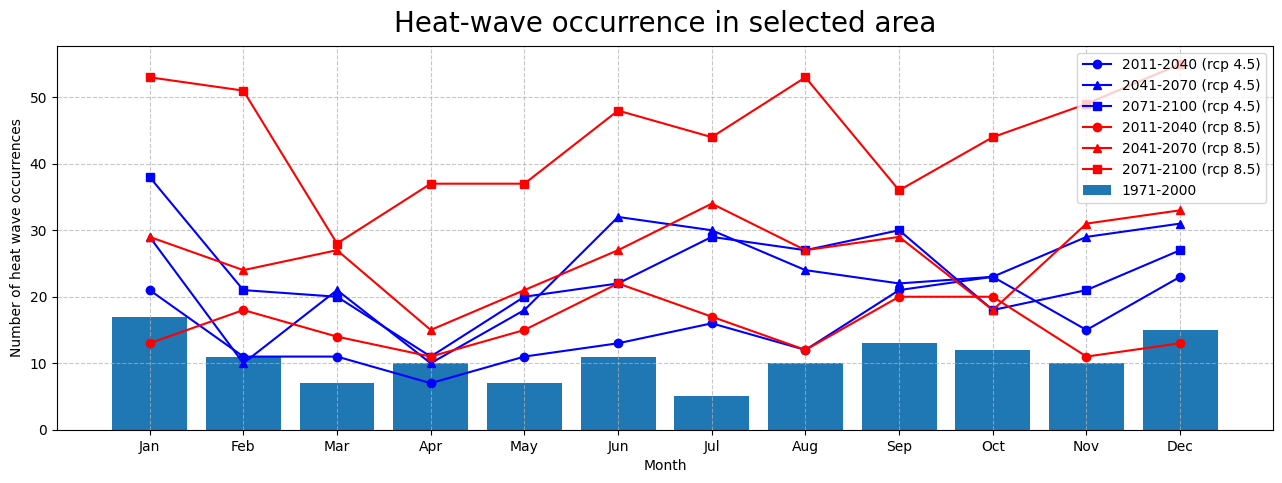

In [13]:
# This code plots the results for the selected point 
#list_values= [pixel_values_p1m, pixel_values_p2m, pixel_values_p3m]
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bar = pixel_values_hm
line1 = pixel_values_p1m_45
line2 = pixel_values_p2m_45
line3 = pixel_values_p3m_45
line4 = pixel_values_p1m_85
line5 = pixel_values_p2m_85
line6 = pixel_values_p3m_85
fig, ax = plt.subplots()
ax.bar(month, bar, label='1971-2000')
ax.plot(month, line1, color='blue', marker='o', label='2011-2040 (rcp 4.5)')
ax.plot(month, line2, color='blue', marker="^", label='2041-2070 (rcp 4.5)')
ax.plot(month, line3, color='blue', marker='s', label='2071-2100 (rcp 4.5)')
ax.plot(month, line4, color='red', marker='o', label='2011-2040 (rcp 8.5)')
ax.plot(month, line5, color='red', marker="^", label='2041-2070 (rcp 8.5)')
ax.plot(month, line6, color='red', marker='s', label='2071-2100 (rcp 8.5)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of heat wave occurrences')
ax.set_title('Heat-wave occurrence in selected area', fontsize=20, pad=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9)
plt.show()

- This graph compares the heat-wave occurrence for month of years 1971-2000 and 2011-2040, 2041-2070, 2071-2100 for RCP 4.5 and 8.5
- **The heat-wave occurrence for months is based on the 90-percentile treshold for each month from reference period 1971-2000. This treshold was used for all projection periods. That's why we can also find heat waves in the winter and autumn months. We should understand the heat-wave occurrence in the winter and autumn months, as a periods when the daily maximum temperature exceeds the 90 percentile temperature treshold computed for the given month from 30 years reference (historical) period 1971-2000.**
- These results give us an idea of heat-wave distribution throughout the year in the past and in the near and far future for different scenarios RCPs
- We need to also realize that the heat occurrence in the winter will have a different impact than the heat occurrence in the summer. The winter heat occurrence can influence the of the snow, animals, and plants for more see [[Heat effects on human nature](https://theconversation.com/four-ways-winter-heatwaves-affect-humans-and-nature-197365)]. The summer heat-waves will have a negative effect on the human health, water scarcity etc. [[Climate adapt effect on human health](https://climate-adapt.eea.europa.eu/en/knowledge/tools/urban-adaptation/climatic-threats/heat-waves)]

### Plot the comparison by years for selected pixel

We compare the heat wave occurrence in the observed period (1971-2000) and projection (2011-2100) for chosen rcp. We selected these periods because these are the most used climate periods by CDS. 

- On this graph you can see the Heat-wave occurence for the reference period 1971-2000 and projection periods 2011-2100
- The number of heat-wave occurence for each year represents the the sum of the heat have occurence for each year (also winter and autumn months)

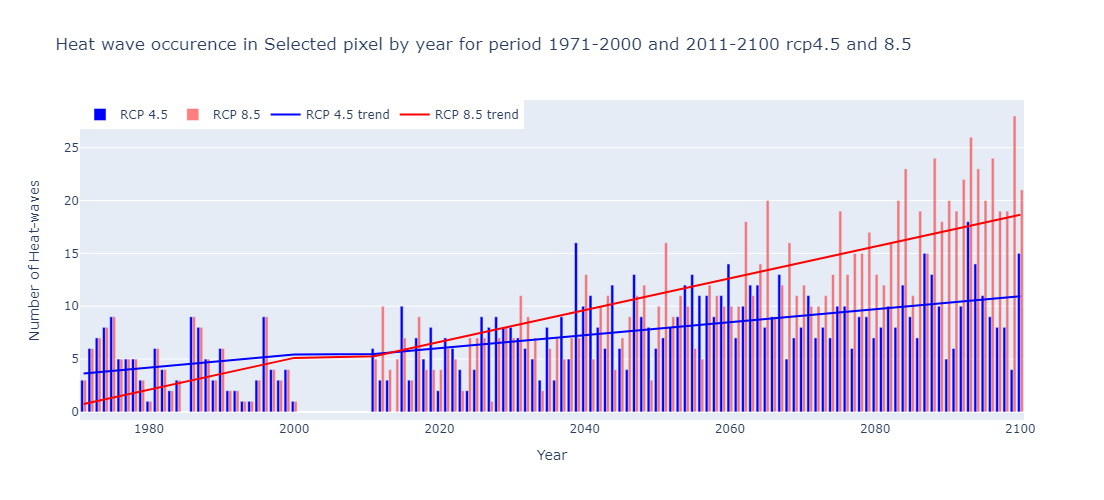

In [33]:
# This code plots the heat-wave occurrence for the selected point for years 
# Sample data
b = pixel_values_hy + pixel_values_p1y_45 + pixel_values_p2y_45 + pixel_values_p3y_45
t = pixel_values_hy + pixel_values_p1y_85 + pixel_values_p2y_85 + pixel_values_p3y_85
# Calculate trend lines for b and t
b_trend = np.polyfit(np.arange(len(b)), b, 1)
t_trend = np.polyfit(np.arange(len(t)), t, 1)
# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP 8.5', opacity=0.5, marker_color='red'))
# Add trend line trace for 'b'
fig.add_trace(go.Scatter(x=year, y=np.polyval(b_trend, np.arange(len(b))), mode='lines', name='RCP 4.5 trend', line=dict(color='blue')))
# Add trend line trace for 't'
fig.add_trace(go.Scatter(x=year, y=np.polyval(t_trend, np.arange(len(t))), mode='lines', name='RCP 8.5 trend', line=dict(color='red')))
# Update layout
fig.update_layout(
    title='Heat wave occurence in Selected pixel by year for period 1971-2000 and 2011-2100 rcp4.5 and 8.5',
    xaxis_title='Year',
    yaxis_title='Number of Heat-waves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500)

### Conclusion for Peseta IV results

Monthly comparison shows in which months we can expect the highest increase in the Heat-wave occurrence. Yearly comparisons show that the trend of Heat-wave occurrence should rise, however, how steep the trendline will be depends on the rcp and area you choose. 

XCLIM is an operational Python library for climate services, providing numerous climate-related indicator tools with an extensible framework for constructing custom climate indicators, statistical downscaling and bias adjustment of climate model simulations, as well as climate model ensemble analysis tools.
XCLIMim is built using xarray and can seamlessly benefit from the parallelization handling provided by dask. Its objective is to make it as simple as possible for users to perform typical climate services data treatment workflows. Leveraging xarray and dask, users can easily bias-adjust climate simulations over large spatial domains or compute indices from large climate datast [[XCLIM](https://xclim.readthedocs.io/en/stable/indicators.html)]


Examples of the code for the computing of the climate indices.
- xclim.indices.heat_wave_max_length(tasmin, tasmax, thresh_tasmin='22.0 degC', thresh_tasmax='30 degC', window=3, freq='YS', op='>', resample_before_rl=True)
  
The thresholds of 22° and 25°C for night temperatures and 30° and 35°C for day temperatures were selected by Health Canada professionals, following a temperature–mortality analysis. These absolute temperature thresholds characterize the occurrence of hot weather events that can result in adverse health outcomes for Canadian communities [Casati et al., 2013].

In Robinson [2001], the parameters would be: thresh_tasmin=27.22, thresh_tasmax=39.44, window=2 (81F, 103F).
Casati, Yagouti, and Chaumont [2013], Robinson [2001]

- The biggest difference vs PESETA IV is that in XCLIM is the treshold for the heat waves calculated directly from the 30 years (rough estimate, identifies heat wave mainly in summer months), while in PESETA IV is calculated for monthly values from 30 years and we can detect also seasonal heat-wave changes. 

### XCLIM packages

In [16]:
# This code imports the XCLIM package
import xclim.indices as xci
import xclim

### Data load
- For XCLIM we are using the same data as for PESETA IV + data about minimum air temperature
- These data are downloaded at the beginning of this notebook

- We can select our own bbox or use the selected one at the begginig of the notebook
- Before proceeding this code you need to run whole section 1

In [12]:
# This code selects the periods and RCPs for the computation of the climate indices by the XCLIM 
# Max T
tasmaxh=tasmaxh.sel(time=slice("1971-01-01", "2000-12-31"))
tasmaxp_45=tasmax45.sel(time=slice("2011-01-01", "2100-12-31"))
tasmaxp_85=tasmax85.sel(time=slice("2011-01-01", "2100-12-31"))
# Min T
tasminh=tasminh.sel(time=slice("1971-01-01", "2000-12-31"))
tasminp_45=tasmin45.sel(time=slice("2011-01-01", "2100-12-31"))
tasminp_85=tasmin85.sel(time=slice("2011-01-01", "2100-12-31"))

### Defining of the temperature tresholds

**Treshold temperatures based on the percentile:**
1. compute the percentile for your selected area
2. calculate the mean value for your selected area

**Treshold temperatures based on the impact on human health:** 
1. based on the preferred studies e.g.: A multi-city epidemiologic study in Europe found that the mortality threshold for heat effects was 29.4 °C for Mediterranean cities and 23.3 °C for the north European cities [[Maximum temperature threshold for EU](https://ehjournal.biomedcentral.com/articles/10.1186/s12940-022-00921-4)].
2. or the thresholds given by your national meteorological or health service. 

In [17]:
# This code uses the XCLIM package for the computation of the climate indices
# Heat-wave index 
# RCP 4.5
HWIp45=xclim.indices.heat_wave_index(tasmaxp_45, thresh='25.0 degC', window=5, freq='YS', op='>', resample_before_rl=True)
# RCP 8.5
HWIp85=xclim.indices.heat_wave_index(tasmaxp_85, thresh='25.0 degC', window=5, freq='YS', op='>', resample_before_rl=True)
# Historical 
HWIh=xclim.indices.heat_wave_index(tasmaxh, thresh='25.0 degC', window=5, freq='YS', op='>', resample_before_rl=True)
#
# Heat-wave frequency
# RCP 4.5
HWFp45=xclim.indices.heat_wave_frequency(tasminp_45, tasmaxp_45, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
# RCP 8.5
HWFp85=xclim.indices.heat_wave_frequency(tasminp_85, tasmaxp_85, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
#Historical
HWFh=xclim.indices.heat_wave_frequency(tasminh, tasmaxh, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
# Data correction
# Set a right type
HWFp45=HWFp45.astype(np.float64)
HWFp85=HWFp85.astype(np.float64)
HWFh=HWFh.astype(np.float64)
#
# Heat-wave total length
# RCP 4.5
HWTLp45=xclim.indices.heat_wave_total_length(tasminp_45, tasmaxp_45, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
# RCP 8.5
HWTLp85=xclim.indices.heat_wave_total_length(tasminp_85, tasmaxp_85, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
# Historical
HWTLh=xclim.indices.heat_wave_total_length(tasminh, tasmaxh, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)

In [ ]:
# This code sets the rotated pole CRS to the calculated data
## CRS for Eurocordex data
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
HWIp45.rio.write_crs(rotated_pole, inplace=True)
HWIp85.rio.write_crs(rotated_pole, inplace=True)
HWIh.rio.write_crs(rotated_pole, inplace=True)
HWFp45.rio.write_crs(rotated_pole, inplace=True)
HWFp85.rio.write_crs(rotated_pole, inplace=True)
HWFh.rio.write_crs(rotated_pole, inplace=True)
HWTLp45.rio.write_crs(rotated_pole, inplace=True)
HWTLp85.rio.write_crs(rotated_pole, inplace=True)
HWTLh.rio.write_crs(rotated_pole, inplace=True)
print("CRS writed!!!")

- This step will take a few minutes

In [19]:
# This code saves the computed indices in the disk in raster tif format 
HWIp45.rio.to_raster(raster_path=f'{data_dir}/HWIp45.tif')
HWIp85.rio.to_raster(raster_path=f'{data_dir}/HWIp85.tif')
HWIh.rio.to_raster(raster_path=f'{data_dir}/HWIh.tif')
HWFp45.rio.to_raster(raster_path=f'{data_dir}/HWFp45.tif')
HWFp85.rio.to_raster(raster_path=f'{data_dir}/HWFp85.tif')
HWFh.rio.to_raster(raster_path=f'{data_dir}/HWFh.tif')
HWTLp45.rio.to_raster(raster_path=f'{data_dir}/HWTLp45.tif')
HWTLp85.rio.to_raster(raster_path=f'{data_dir}/HWTLp85.tif')
HWTLh.rio.to_raster(raster_path=f'{data_dir}/HWTLh.tif')

### Select the pixel for plotting 

In [4]:
# This code reprojects the computed indices to the WGS84 (EPSG:4326)
# Define the files and their corresponding variables
file_variables = [
    ("HWIp45.tif", "HWIp45"),
    ("HWIp85.tif", "HWIp85"),
    ("HWIh.tif", "HWIh"),
    ("HWFp45.tif", "HWFp45"),
    ("HWFp85.tif", "HWFp85"),
    ("HWFh.tif", "HWFh"),
    ("HWTLp45.tif", "HWTLp45"),
    ("HWTLp85.tif", "HWTLp85"),
    ("HWTLh.tif", "HWTLh")
]
# Define the target CRS
target_crs = 'EPSG:4326'  # WGS84
# Iterate over each file and variable
for filename, var_name in file_variables:
    # Open the raster dataset
    data = xr.open_dataset(f'{data_dir}/{filename}')['band_data']   
    # Write the CRS information to the dataset
    data.rio.write_crs(rotated_pole, inplace=True)  
    # Reproject the clipped raster dataset to the target CRS
    reprojected_data = data.rio.reproject(target_crs)
    # Replace NaN values
    reprojected_data.where(reprojected_data != 1.7976931348623157e+308, np.nan)   
    # Optionally, you can save the reprojected raster to a new file
    reprojected_data.rio.to_raster(raster_path=f'{data_dir}/{var_name}_reprojected.tif') 
    # Calculate mean and save to file
    mean_data = reprojected_data.mean(dim='band', skipna=True, keep_attrs=True)
    mean_data.rio.to_raster(raster_path=f'{data_dir}/{var_name}_m.tif')

In [5]:
# This code plots the map where we need to select the point for the plot of the graphs for computed indices
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/HWIp85_m.tif')
client2 = TileClient(f'{data_dir}/HWFp85_m.tif')
client3 = TileClient(f'{data_dir}/HWTLp85_m.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave index')
t2 = get_leaflet_tile_layer(client2, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave frequency')
t3 = get_leaflet_tile_layer(client3, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave total length')
m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client2.center(), zoom=client2.default_zoom)
m = Map(center=client3.center(), zoom=client3.default_zoom)
m.add(t1)
m.add(t2)
m.add(t3)
control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

- In the picture above, we can find the plotted raster data in the area that we select by bbox at the beginning of the code
- These rasters provide three types of data, which you can select in the right upper corner
- These data are scaled for Heat-wave Index, Heat-wave frequency, and Heat-wave total length (total duration) for the projected period 2011-2100
- This graphical comparison is only for the better imagination of which place in your selected area will more suffer from heat (dark red will be most affected)
- For the visual comparison of the number of heat occurrences you need to select a point (flag) from the left panel and select a pixel that you prefer
- **The skewness of the rasters was caused by the transformation of the coordinates system** 

In [7]:
# This code extracts the values from the computed indices for the selected pixel 
def get_pixel_values(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        
        # Read pixel values from each band
        pixel_values = [band[row, col] for band in src.read()]
        
        # Return pixel values for each band
        return pixel_values

# Example usage
raster_file_hwi45 = f'{data_dir}/HWIp45_reprojected.tif'
raster_file_hwi85 = f'{data_dir}/HWIp85_reprojected.tif'
raster_file_hwih = f'{data_dir}/HWIh_reprojected.tif'
raster_file_hwf45 = f'{data_dir}/HWFp45_reprojected.tif'
raster_file_hwf85 = f'{data_dir}/HWFp85_reprojected.tif'
raster_file_hwfh = f'{data_dir}/HWFh_reprojected.tif'
raster_file_hwtl45 = f'{data_dir}/HWTLp45_reprojected.tif'
raster_file_hwtl85 = f'{data_dir}/HWTLp85_reprojected.tif'
raster_file_hwtlh = f'{data_dir}/HWTLh_reprojected.tif'
# extract lat lon from map
lat = point_lat_list[0]
lon = point_lon_list[0]
# extract values for selected pixel 
pixel_values_hwi45 = get_pixel_values(raster_file_hwi45, lat, lon)
pixel_values_hwi85 = get_pixel_values(raster_file_hwi85, lat, lon)
pixel_values_hwih = get_pixel_values(raster_file_hwih, lat, lon)
pixel_values_hwf45 = get_pixel_values(raster_file_hwf45, lat, lon)
pixel_values_hwf85 = get_pixel_values(raster_file_hwf85, lat, lon)
pixel_values_hwfh = get_pixel_values(raster_file_hwfh, lat, lon)
pixel_values_hwtl45 = get_pixel_values(raster_file_hwtl45, lat, lon)
pixel_values_hwtl85 = get_pixel_values(raster_file_hwtl85, lat, lon)
pixel_values_hwtlh = get_pixel_values(raster_file_hwtlh, lat, lon)

### Plots the Heat-wave index (HWI)
Number of days that are part of a heatwave, defined as five or more consecutive days over a threshold of 25 degrees.

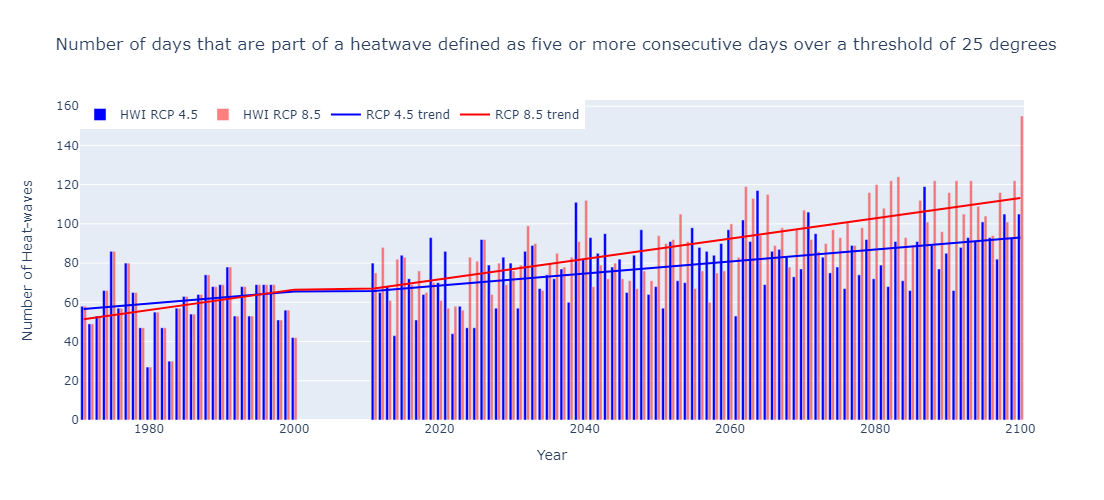

In [21]:
# This code plots the data with Heat-wave index for the selected pixel 
# Sample data
b = pixel_values_hwih + pixel_values_hwi45
t = pixel_values_hwih + pixel_values_hwi85 
# Calculate trend lines for b and t
b_trend = np.polyfit(np.arange(len(b)), b, 1)
t_trend = np.polyfit(np.arange(len(t)), t, 1)
# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='HWI RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='HWI RCP 8.5', opacity=0.5, marker_color='red'))
# Add trend line trace for 'b'
fig.add_trace(go.Scatter(x=year, y=np.polyval(b_trend, np.arange(len(b))), mode='lines', name='RCP 4.5 trend', line=dict(color='blue')))
# Add trend line trace for 't'
fig.add_trace(go.Scatter(x=year, y=np.polyval(t_trend, np.arange(len(t))), mode='lines', name='RCP 8.5 trend', line=dict(color='red')))
# Update layout
fig.update_layout(
    title='Number of days that are part of a heatwave defined as five or more consecutive days over a threshold of 25 degrees',
    xaxis_title='Year',
    yaxis_title='Number of Heat-waves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500)

### Plots the Heat-wave frequency
- Number of heat waves over a given period. A heat wave is defined as an event where the minimum and maximum daily temperature both exceed specific thresholds over a minimum number of days.
- The number of the heat-waves depends strictly on the treshold which we select


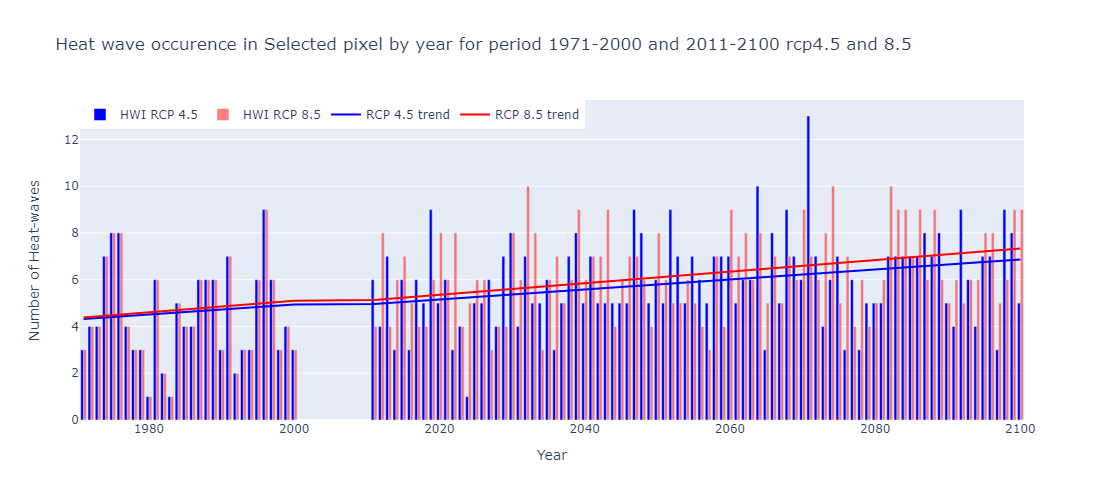

In [9]:
# This code plots the data with Heat-wave frequency for the selected pixel 
# Sample data
b = pixel_values_hwfh + pixel_values_hwf45
t = pixel_values_hwfh + pixel_values_hwf85 
# Calculate trend lines for b and t
b_trend = np.polyfit(np.arange(len(b)), b, 1)
t_trend = np.polyfit(np.arange(len(t)), t, 1)
# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='HWI RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='HWI RCP 8.5', opacity=0.5, marker_color='red'))
# Add trend line trace for 'b'
fig.add_trace(go.Scatter(x=year, y=np.polyval(b_trend, np.arange(len(b))), mode='lines', name='RCP 4.5 trend', line=dict(color='blue')))
# Add trend line trace for 't'
fig.add_trace(go.Scatter(x=year, y=np.polyval(t_trend, np.arange(len(t))), mode='lines', name='RCP 8.5 trend', line=dict(color='red')))
# Update layout
fig.update_layout(
    title='Heat wave occurence in Selected pixel by year for period 1971-2000 and 2011-2100 rcp4.5 and 8.5',
    xaxis_title='Year',
    yaxis_title='Number of Heat-waves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500)

### Plots the Heat-wave total length
Total length of heat waves over a given period. A heat wave is defined as an event where the minimum and maximum daily temperature both exceeds specific thresholds over a minimum number of days. This the sum of all days in such events.

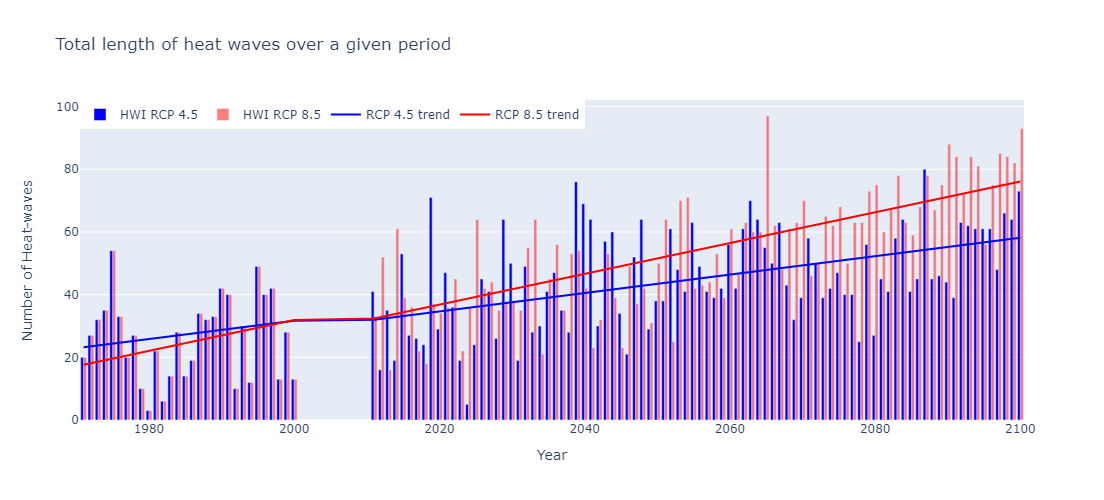

In [22]:
# This code plots the data with Heat-wave total length for the selected pixel 
# Sample data
b = pixel_values_hwtlh + pixel_values_hwtl45
t = pixel_values_hwtlh + pixel_values_hwtl85 
# Calculate trend lines for b and t
b_trend = np.polyfit(np.arange(len(b)), b, 1)
t_trend = np.polyfit(np.arange(len(t)), t, 1)
# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='HWI RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='HWI RCP 8.5', opacity=0.5, marker_color='red'))
# Add trend line trace for 'b'
fig.add_trace(go.Scatter(x=year, y=np.polyval(b_trend, np.arange(len(b))), mode='lines', name='RCP 4.5 trend', line=dict(color='blue')))
# Add trend line trace for 't'
fig.add_trace(go.Scatter(x=year, y=np.polyval(t_trend, np.arange(len(t))), mode='lines', name='RCP 8.5 trend', line=dict(color='red')))
# Update layout
fig.update_layout(
    title='Total length of heat waves over a given period',
    xaxis_title='Year',
    yaxis_title='Number of Heat-waves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500)

### Conclusion for the XCLIM results 
- We calculated three climate indices connected to extreme temperature: Heat-wave index, Heat-wave frequency, and Heat-wave total length for two climate scenarios RCP 4.5 and 8.5 based on the Euro-Cordex data. 
- The results depend on the area and point that you select for the plotting of the graphs 